In [240]:
%run DL_func.ipynb

In [241]:
from sklearn.metrics import r2_score

The first step consists of generating the synthetic data. The data is generated from the graph shown belown. Z denotes the unobserved latent variables, Y is the target variable which will be assumed observed (i.e. in the cow/camel classification problem 'Y' will correspond to the label 'cow' / 'camel'). X is the observed features as is generated from Z via a neural network. In the cow / camel classification problem 'X' would correspond to the actual image. Finally, an environment variable E is introduced. The environment determines the mean of the gaussian distribution the Z's are drawn from. The generative process for each of the variables is as follows:

$$Z_1 = \mathcal{N}(E, \sigma=1)$$
$$Z_2 = \mathcal{N}(2E, \sigma=2)$$
$$Y = \mathcal{N}(\alpha_1 \cdot Z_1+\alpha_2 \cdot Z_2, \sigma=1)$$
$$Y = \mathcal{N}(\alpha_3 \cdot Y, \sigma=1)$$
$$X = g(Z_1, Z_2, Z_3)$$

Where g is a randomly initialized neural network. All of the alphas are in this case set to 1.

First off, the Y's and Z's are generated from 4 different environments. 1000 samples from each environment is drawn.

In [242]:
E_choice, Env, Y, Z = generate_z_and_y(np.array([0.2, 2, 3, 5]), 8000)

Samples from the generative process is shown in the below dataframe along with markers of which environment a sample was drawn from and the corresponding 'mean' of that environment.

In [243]:
df=pd.concat([p(Z), p(Y), p(Env), p(E_choice)],axis=1)
df.columns = ['Z1', 'Z2', 'Z3', 'Y', 'Env_mean', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
tdf=df
df.round(2)

,Z1,Z2,Z3,Y,Env_mean,Env,c
0,5.79,10.86,16.05,15.37,5.0,3,yellow
1,3.62,3.93,8.50,7.39,2.0,1,blue
2,3.38,1.48,3.01,4.31,2.0,1,blue
3,2.51,4.18,6.76,7.09,3.0,2,green
4,2.56,5.20,8.71,8.66,2.0,1,blue
...,...,...,...,...,...,...,...
7995,2.25,1.65,4.95,4.23,2.0,1,blue
7996,4.20,10.95,15.32,15.30,5.0,3,yellow
7997,4.38,4.85,9.86,8.14,3.0,2,green
7998,2.90,4.01,8.20,7.36,3.0,2,green


Figure x shows a 3d-plot of the samples in (Z1, Z2, Z3)-space coloured by environment.

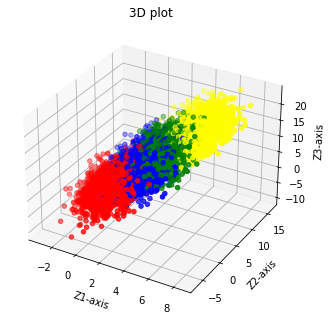

In [244]:
# for creating a responsive plot
#%matplotlib qt
%matplotlib inline

plot_latent_3d(df, m)

Finally, the observed X-values are generated via a randomly initialized neural network with 6 hidden units and 10 output units.

In [245]:
net=Net(3, 6, 10)
X=net(torch.from_numpy(Z.astype("float32"))).detach().numpy()

In [246]:
dset = EnvDataset(X[:4000],Y[:4000],E_choice[:4000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[4000:],Y[4000:],E_choice[4000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)
x,y,e = next(iter(train_loader))

In [247]:
import pdb
class iCARL(nn.Module):
    def __init__(self, x, y, e, input_size, output_size, input_size_de, output_size_de, input_size_pr, output_size_pr, y_dim, beta=1):
        super().__init__()
        # Encoder
        self.func_en = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=2*output_size)
            )
        
                # Decoder
        self.func_de = nn.Sequential(
                nn.Linear(in_features=input_size_de, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=output_size_de)
            )
        
        # Prior
        self.TNN = nn.Sequential(
            nn.Linear(in_features=input_size_de, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=y_dim*2)
        )
        
        self.lambdaNN = nn.Sequential(
            nn.Linear(in_features=ye_dim, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=y_dim*2)
        )
        
        self.lambdaf = nn.Sequential(
            nn.Linear(in_features=ye_dim, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=input_size_de*2*2)
        )
        
        self.normal_dist = Normal_dist()
        
        
    
    def forward(self, x, y, e, beta=1):
        # Format input
        xye=torch.cat((x, y, e), 1)
        
        # Get encoder params
        z_usigma = self.func_en(xye)
        zu, zsigma = z_usigma.chunk(2, dim = -1) # Get mu and sigma
        zsigma = zsigma.exp()
        encoder_params = zu, zsigma

        # Sample Z
        z = self.normal_dist.sample(zu, zsigma)

        # Get decoder params
        de_u = self.func_de(z)
        
        # Get prior params
        #ye = torch.cat((y, e), 1)
        #prior_u, prior_sigma = self.func(ye).chunk(2, axis = -1)
        #prior_sigma = prior_sigma.exp()
        
        return zu, zsigma, de_u, z
    
    def elbo(self, x, y, e, beta=1):
        # Get encoder and decoder params
        zu, zsigma, de_u, z = self.forward(x, y, e)
        
        # Samples from distributions with the acquired parameters
        lvar = 0.01*torch.ones(1).to('cpu')
        log_px_z = self.normal_dist.log_pdf(x, de_u, lvar) # p(x | u, sigma)
        log_qz_xye = self.normal_dist.log_pdf(z, zu, zsigma)
        
        z_temp = z.detach().requires_grad_(requires_grad = True)
        
        # Get prior params
        ye = torch.cat((y.detach(),e.detach()),1)
        
        TNN_params, _ = self.TNN(z_temp).chunk(2, axis = -1)
        lambdaNN_params, _ = self.lambdaNN(ye).chunk(2, axis = -1)
        lambdaf_params, _ = self.lambdaf(ye).chunk(2, axis = -1)
        
        nn_ = (TNN_params*lambdaNN_params).sum(dim = 1)
        z_cat = torch.cat((z_temp, z_temp.pow(2)), dim = 1)
        f_ = (z_cat * lambdaf_params).sum(dim = 1)
        pz_ye = nn_ + f_
        
        dpz_ye = torch.autograd.grad(pz_ye.sum(), z_temp, create_graph = True, retain_graph = True)[0]
        ddpz_ye = torch.autograd.grad(dpz_ye.sum(), z_temp, create_graph = True, retain_graph = True)[0]
        
        SM = (ddpz_ye + 0.5 * dpz_ye.pow(2)).sum(1)

        elbo = log_px_z - log_qz_xye + pz_ye.detach()

        return elbo.mean()-SM.mean(), elbo.mean(), SM.mean()

    
    

In [248]:
z_dim = 3
x_y_e = 15
x_dim = 10
ye_dim = 5
y_dim = 1
net=iCARL(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, ye_dim, z_dim, y_dim, beta=1)

In [249]:
x,y,e = next(iter(train_loader))
elbo_SM, elbo, SM = net.elbo(x.float(),y.float(),e.float())

In [250]:
elbo_SM, elbo, SM

(tensor(-1668.3571, grad_fn=<SubBackward0>),
 tensor(-1664.7815, grad_fn=<MeanBackward0>),
 tensor(3.5756, grad_fn=<MeanBackward0>))

In [251]:
from torch.optim import Adam
optimizer = Adam(net.parameters(), lr=1e-3)

epochs = 100
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss, elbo, SM = net.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)

Epoch 20 of 100
Train loss: tensor(-49.4139)
Epoch 40 of 100
Train loss: tensor(-106.7661)
Epoch 60 of 100
Train loss: tensor(-94.5834)
Epoch 80 of 100
Train loss: tensor(-78.2614)
Epoch 100 of 100
Train loss: tensor(-72.2004)


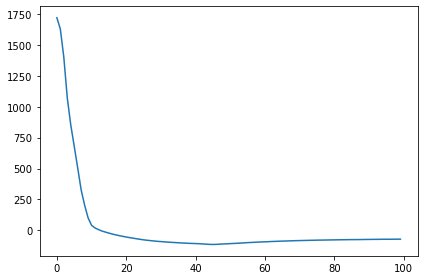

In [252]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_loss)
plt.show()

In [253]:
# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 3))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    _, _, _, z = net.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1

In [254]:
df=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df.columns = ['Z1', 'Z2', 'Z3', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
#df.round(2)

In [255]:
df

,Z1,Z2,Z3,Env,c
0,7.824919,-2.907690,3.320219,1,blue
1,13.842018,-0.254995,4.334280,3,yellow
2,6.000327,-2.697134,1.131174,1,blue
3,11.216462,-0.156017,5.168384,3,yellow
4,8.502424,-1.610113,0.168515,2,green
...,...,...,...,...,...
3963,11.846821,-3.879365,1.841081,2,green
3964,7.414715,-2.099005,0.582662,1,blue
3965,10.287837,-4.230096,4.364479,2,green
3966,0.651827,-0.936756,-0.384118,0,red


In [256]:
#%matplotlib qt
#plot_latent_3d(df, m)

In [257]:
pdf=df[['Z1', 'Z2', 'Z3']]
pdf.columns = ['pZ1', 'pZ2', 'pZ3']
cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[4000:7968,:]
#cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[:1920,:]
cdf['pZ1']=pdf['pZ1'].values
cdf['pZ2']=pdf['pZ2'].values
cdf['pZ3']=pdf['pZ3'].values

corrs=cdf.corr().iloc[:3,3:]
mcc=corrs.max().mean()
mcc_abs=np.abs(corrs).max().mean()
mcc, mcc_abs

(0.47193068982742964, 0.8464663553360611)

In [258]:
def MCC(true_z, predicted_z):
    """Caluclates the Correlation Coefficient between all pairs of true 
    and recovered latent variables for one environment 

    Uses Pearsons Corr Coef

    from paper: 
    We also compute the mean correlation coefficient (MCC) used in Khemakhem et al. (2020a), which
    can be obtained by calculating the correlation coefficient between all pairs of true and recovered
    latent factors and then solving a linear sum assignment problem by assigning each recovered latent
    factor to the true latent factor with which it best correlates

    Args:
        true_z (numpy array): 2D dimensional numpy array, where columns represent variables
        predicted_z (numpy array): _description_
    """
    num_true = len(true_z[0])
    num_predicted = len(predicted_z[0])
    corr_matrix = np.abs(np.corrcoef(true_z, predicted_z, rowvar=False))
    reduced_matrix = corr_matrix[
        0:num_true, num_true : len(corr_matrix[0]) + 1
    ]  # where rows are true and columns are predicted
    row_ind, col_ind = linear_sum_assignment(reduced_matrix, maximize=True)

    mcc = [reduced_matrix[row_ind[i], col_ind[i]] for i in range(len(row_ind))]
    print(mcc)
    mcc = np.sum(mcc) / (num_predicted)
    return mcc

In [259]:
MCC(cdf.iloc[:,:3].values, pdf.values)

[0.6095514056186053, 0.9818096493560426, 0.9480380110335391]


0.8464663553360623

In [260]:
def MCC(true_z, predicted_z):
    """Caluclates the Correlation Coefficient between all pairs of true 
    and recovered latent variables for one environment 

    Uses Pearsons Corr Coef

    from paper: 
    We also compute the mean correlation coefficient (MCC) used in Khemakhem et al. (2020a), which
    can be obtained by calculating the correlation coefficient between all pairs of true and recovered
    latent factors and then solving a linear sum assignment problem by assigning each recovered latent
    factor to the true latent factor with which it best correlates

    Args:
        true_z (numpy array): 2D dimensional numpy array, where columns represent variables
        predicted_z (numpy array): _description_
    """
    num_true = len(true_z[0])
    num_predicted = len(predicted_z[0])
    corr_matrix = np.abs(np.corrcoef(true_z, predicted_z, rowvar=False))
    reduced_matrix = corr_matrix[
        0:num_true, num_true : len(corr_matrix[0]) + 1
    ]  # where rows are true and columns are predicted
    row_ind, col_ind = linear_sum_assignment(reduced_matrix)

    mcc = [reduced_matrix[row_ind[i], col_ind[i]] for i in range(len(row_ind))]
    print(mcc)
    mcc = np.sum(mcc) / (num_predicted)
    return mcc

MCC(cdf.iloc[:,:3].values, pdf.values)

[0.8093512644865766, 0.8262840419487216, 0.5747607978375904]


0.7367987014242962

In [261]:
import pingouin as pg
from sklearn.linear_model import LinearRegression
df['Y']=Y[4000:7968]

dfc=pd.concat([df,pd.get_dummies(df['Env'],drop_first=True)],axis=1)
dfc['Z1x_1']=dfc['Z1']*dfc[1]
dfc['Z1x_2']=dfc['Z1']*dfc[2]
dfc['Z1x_3']=dfc['Z1']*dfc[3]
dfc['Z2x_1']=dfc['Z2']*dfc[1]
dfc['Z2x_2']=dfc['Z2']*dfc[2]
dfc['Z2x_3']=dfc['Z2']*dfc[3]
dfc['Z3x_1']=dfc['Z3']*dfc[1]
dfc['Z3x_2']=dfc['Z3']*dfc[2]
dfc['Z3x_3']=dfc['Z3']*dfc[3]
train=dfc.iloc[:1600,:]
test=dfc.iloc[:1600,:]

In [262]:
def predict_y(df, x_train, y_train, x_test, y_test, linear=True):
    if linear:
        lm = pg.linear_regression(x_train,y_train)#, add_intercept=False)
        print(lm)
        reg = LinearRegression().fit(x_train, y_train)
        y_pred = reg.predict(x_test)
        print(r2_score(y_pred, y_test))
        
        return y_pred
    
    

In [263]:
train=df.iloc[:4000,:]
test=df.iloc[:4000,:]

In [264]:
y_pred=predict_y(dfc, train[['Z1', 'Z2', 'Z3']], train['Y'], test[['Z1', 'Z2', 'Z3']], test['Y'])
#y_pred=predict_y(dfc, train[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 train['y'], test[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 test['y'])
y_pred=predict_y(dfc, train[['Z1', 'Z2']], train['Y'], test[['Z1', 'Z2']], test['Y'])
y_pred=predict_y(dfc, train[['Z3']], train['Y'], test[['Z3']], test['Y'])

       names      coef        se           T          pval        r2  \
0  Intercept -0.257456  0.038084   -6.760202  1.579365e-11  0.971418   
1         Z1  0.735923  0.006209  118.534792  0.000000e+00  0.971418   
2         Z2 -0.040749  0.012152   -3.353185  8.063691e-04  0.971418   
3         Z3  0.949837  0.014632   64.915880  0.000000e+00  0.971418   

     adj_r2  CI[2.5%]  CI[97.5%]  
0  0.971397 -0.332122  -0.182789  
1  0.971397  0.723751   0.748095  
2  0.971397 -0.064574  -0.016924  
3  0.971397  0.921151   0.978524  
0.9705772848940206
       names      coef        se           T           pval        r2  \
0  Intercept -1.745661  0.043675  -39.969167  7.716560e-294  0.941033   
1         Z1  1.061356  0.005260  201.781049   0.000000e+00  0.941033   
2         Z2 -0.343039  0.016120  -21.279709   3.072836e-95  0.941033   

     adj_r2  CI[2.5%]  CI[97.5%]  
0  0.941004 -1.831289  -1.660033  
1  0.941004  1.051044   1.071668  
2  0.941004 -0.374644  -0.311433  
0.9373384028

In [265]:
y_pred=predict_y(dfc, train[['Z1', 'Z2', 'Z3']], train['Y'], test[['Z1', 'Z2', 'Z3']], test['Y'])
#y_pred=predict_y(dfc, train[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 train['y'], test[['Z1', 'Z2', 1, 2, 3, 'Z1x_1', 'Z1x_2', 'Z1x_3', 'Z2x_1', 'Z2x_2', 'Z2x_3']],
#                 test['y'])
y_pred=predict_y(dfc, train[['Z1', 'Z2']], train['Y'], test[['Z1', 'Z2']], test['Y'])
y_pred=predict_y(dfc, train[['Z3']], train['Y'], test[['Z3']], test['Y'])

       names      coef        se           T          pval        r2  \
0  Intercept -0.257456  0.038084   -6.760202  1.579365e-11  0.971418   
1         Z1  0.735923  0.006209  118.534792  0.000000e+00  0.971418   
2         Z2 -0.040749  0.012152   -3.353185  8.063691e-04  0.971418   
3         Z3  0.949837  0.014632   64.915880  0.000000e+00  0.971418   

     adj_r2  CI[2.5%]  CI[97.5%]  
0  0.971397 -0.332122  -0.182789  
1  0.971397  0.723751   0.748095  
2  0.971397 -0.064574  -0.016924  
3  0.971397  0.921151   0.978524  
0.9705772848940206
       names      coef        se           T           pval        r2  \
0  Intercept -1.745661  0.043675  -39.969167  7.716560e-294  0.941033   
1         Z1  1.061356  0.005260  201.781049   0.000000e+00  0.941033   
2         Z2 -0.343039  0.016120  -21.279709   3.072836e-95  0.941033   

     adj_r2  CI[2.5%]  CI[97.5%]  
0  0.941004 -1.831289  -1.660033  
1  0.941004  1.051044   1.071668  
2  0.941004 -0.374644  -0.311433  
0.9373384028

In [266]:
graphdf=df[['Z1', 'Z2', 'Z3', 'Y']]

In [267]:
graphdf.values

array([[ 7.82491922, -2.90768981,  3.32021904,  9.30340323],
       [13.84201813, -0.25499511,  4.33427954, 14.21444629],
       [ 6.00032711, -2.69713402,  1.13117373,  6.00291055],
       ...,
       [10.28783703, -4.23009634,  4.36447859, 10.41372533],
       [ 0.65182722, -0.93675637, -0.38411808,  0.36940547],
       [ 3.14683414, -0.60117912,  0.1181155 ,  3.40029041]])

In [268]:
from causallearn.utils.cit import CIT
kci_obj = CIT(graphdf.values, "kci") 
kci_obj(0,1, {2})
#pE = kci_obj(0, 1, {3})
#pYE = kci_obj(0, 1, {2, 3})

0.0

  0%|          | 0/4 [00:00<?, ?it/s]

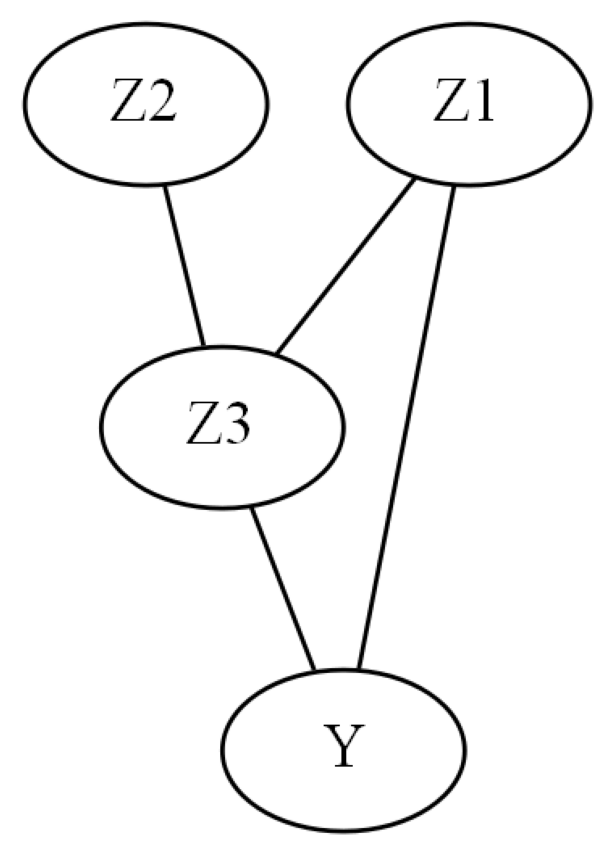

In [269]:
%matplotlib inline
from causallearn.search.ConstraintBased.PC import pc   
cg = pc(graphdf.values, 0.05)
# visualization using pydot
cg.draw_pydot_graph(labels = graphdf.columns)